# EEG Dataset Processing Pipeline

Scope:
- Process a raw EEG dataset 
- Dataset containing the results of an EEG study on multiple subjects
- Dataset that has been downloaded from OpenNeuro, and structured as per the BIDS standard, and in EEGLab '.set' format

Parameters:
- Defined as part of the Study Class

The Pipeline Stages (For each subject in an EEG study dataset):
- EEG Dataset Load - Get the raw source EEG signal data
- EEG Preprocessing - Execute filtering etc of the raw EEG time series data
- Power Spectra (PSD) Calculate - Calculate the power spectra, for all channels recorded
- Spectral Parameterisation - Determine the best fitting Aperiodic and Periodic components
- Features Set - Collate & save the study, subject and EEG data into a features set, Pandas Dataframe


## TO DO - To Review

Projects:
- Perplexity project: https://www.perplexity.ai/search/i-am-building-a-pipeline-in-py-sVmw70rHQXa0VKkIT_p5tg?0=r
- Python Handbook: https://github.com/ZitongLu1996/Python-EEG-Handbook/tree/master

## Dependencies

General dependencies:
- python = 3.11.13
- numpy = 2.0.2
- scipy = 1.15.3
- pandas = 2.2.3
- matplotlib = 3.10.3

ML dependencies:
- scikit-learn = 1.6.1

EEG specific dependencies:
- mne = 1.9.0
- mne-icalabel = 0.7.0
- specparam = 2.0.0rc3

## Python-MNE

Used for Import:
- MNE-Python: https://mne.tools/stable/index.html
- The Brain Imaging Data Structure (BIDS): https://bids.neuroimaging.io

EEG Data Format for Processing:
- In FIF format (Functional Image File Format): https://www.perplexity.ai/search/having-read-some-eeg-data-usin-70hxIA1KSZu6VdV.MfLY_A

Used for Power Spectrum Calculate
- MNE vs NeuroDSP: https://www.perplexity.ai/search/using-python-which-package-is-zOoiPqUvTnKbO.QfgmPsJQ

Formats:
- Assumes OpenNeuro, BIDS compliant datasets manually downloaded into the defined folders structure
- Assumes EEGLab '.set' format


## Spectral Parameterisation

Spectral Parameterisation:
- The Aperiodic Methods project - Documentation: https://aperiodicmethods.github.io/docs/index.html and Repo: in https://github.com/AperiodicMethods/AperiodicMethods
- And cite: https://www.biorxiv.org/content/10.1101/2024.09.15.613114v1

Documentation:
- SpecParam: https://specparam-tools.github.io and https://github.com/fooof-tools
- FOOOF: https://fooof-tools.github.io/fooof/ and https://github.com/fooof-tools/fooof

FOOOF vs SpecPram:
- FOOOF: More stable and used but deprecated
- SpecParam: Release candidate but some improved model/fit selection: https://pmc.ncbi.nlm.nih.gov/articles/PMC11326208/
- Summary: https://www.perplexity.ai/search/using-python-which-package-is-M7kzhERoTLuCrIKbXxN9sQ


# Imports & Utilities

In [1]:
# Not availble through a Conda install/environment - PIP Install may be required
# %pip install specparam


In [2]:
# General imports
import os
import gc
from datetime import datetime
from pprint import pprint
import time
import pickle
import random

import math
import numpy as np
import pandas as pd
import scipy as sci

# Plots
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# MNE-Python
import mne
from mne.preprocessing import ICA
from mne_icalabel import label_components

# SpecParam
from specparam import SpectralGroupModel
from specparam.plts.spectra import plot_spectra

# Check the version of SpecParam
from specparam import __version__ as specparam_version
print('Current SpecParam version:', specparam_version)


Current SpecParam version: 2.0.0rc3


In [3]:
# Utility function to establish relative paths for a given folder
def get_folder_path(folder_name, data_folder='Data'):
    project_root = os.path.dirname(os.getcwd())
    folder_path = os.path.join(project_root, data_folder, folder_name)
    if not os.path.isdir(folder_path):
        raise FileNotFoundError(f'Directory not found: {folder_path}')  
    return folder_path

# Utility function to create a new folder path, if not exists
def make_folder_path(folder_name, data_folder='Data', exists_ok=True):
    project_root = os.path.dirname(os.getcwd())
    folder_path = os.path.join(project_root, data_folder, folder_name)
    if os.path.exists(folder_path):
        if not exists_ok:
            raise FileExistsError(f"Directory already exists: {folder_path}")
    else:
        os.makedirs(folder_path)
    return folder_path

 # Utility function to extend an existing folder path with a subfolder
def extend_folder_path(base_folder, subfolder, exists_ok=True):
    if not os.path.isdir(base_folder):
        raise FileNotFoundError(f'Parent directory not found: {base_folder}')
    extended_path = os.path.join(base_folder, subfolder)
    if os.path.exists(extended_path):
        if not exists_ok:
            raise FileExistsError(f"Directory already exists: {extended_path}")
    else:
        os.makedirs(extended_path)
    return extended_path

# Utility function to check for the existence of a file in a given folder
def get_file_path(folder, file_name):
    file_path = os.path.join(folder, file_name)
    if not os.path.isfile(file_path):
        raise FileNotFoundError(f'File not found: {file_path}')
    return file_path


# Classes & Functions

## Get Raw EEG data

In [4]:
# Function to get the raw EEG signal data
def get_EEG_raw(dataset_path, subject_id):
    """
    Get raw EEG data.

    Parameters
    ----------
    dataset_path : str
    subject_id : str

    Returns
    -------
    EEG_raw : FIF
    """

    flag_verbose = (True if 'VERBOSE' in globals() and VERBOSE else False)

    # BIDS File Structure
    # dataset_root = 
    # dataset_name = 
    subject = subject_id
    session = ''
    task = 'Rest'
    datatype='eeg'

    # Cater for none or multiple sessions, eg 'ses-01', 'ses-02'
    temp_path = os.path.join(dataset_path, subject)
    subfolders = [f for f in os.listdir(temp_path) if os.path.isdir(os.path.join(temp_path, f))]
    if 'eeg' in subfolders:
        session = ''
    elif any(f.startswith('ses-') for f in subfolders):
        session = sorted([f for f in subfolders if f.startswith('ses-')])
    else:
        raise FileNotFoundError(f"No 'eeg' or session folder found in {temp_path}")
    
    # Cater for 0 or multiple sessions
    # print(f'Test Found: {session}')
    sessions_eeg_raw = []
    if session == '':
        temp_path = os.path.join(dataset_path, subject, datatype)
        temp_file_name = subject + '_task-' + task + '_' + datatype + '.set'
        eeg_lab_file_path = get_file_path(temp_path, temp_file_name)
        try:
            eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)
            sessions_eeg_raw.append(eeg_dataset_raw)
        except Exception as e:
            raise ValueError(f"Failed to load EEG data for subject {subject}: {e}")
    else:
        for next_session in session:
            temp_path = os.path.join(dataset_path, subject, next_session, datatype)
            temp_file_name = subject + '_' + next_session + '_task-' + task + '_' + datatype + '.set'
            eeg_lab_file_path = get_file_path(temp_path, temp_file_name)
            # print(f'Test session path: {eeg_lab_file_path}')
            try:
                eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)
                sessions_eeg_raw.append(eeg_dataset_raw)
            except Exception as e:
                raise ValueError(f"Failed to load EEG data for subject {subject}: {e}")
    
    return sessions_eeg_raw

In [5]:
# Function to plot EEG Time Series
def plot_EEG_TD(eeg_FIF, channels, time_range_s=[]):
    """
    EEG Time Domain Plot.

    Parameters
    ----------
    eeg_FIF : FIF
    channels : [str] eg ['P5', 'Pz']
    time_range_s : [nn,nn]
    """

    # Channels Limit
    max_plots = 5
    if len(channels) > max_plots:
        channels = channels[:max_plots]

    start = (time_range_s[0] * 500) if time_range_s else 0
    stop = (time_range_s[1] * 500) if time_range_s else 999999


    # Get signal and times for the elected channel(s)
    signal, times = eeg_FIF.get_data(picks=channels, 
                                     start=start, stop=stop,
                                     return_times=True)
    # signal = np.squeeze(signal)

    plt.figure(figsize=(12, 8))
    for i, ch_name in enumerate(channels):
        plt.plot(times, signal[i] * 1e6, label=ch_name, alpha=0.7, linewidth=0.6)
    plt.title('EEG Time Series - Channels: ' + ', '.join(channels))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    plt.tight_layout()
    plt.show()

## EEG Preprocessing

In [6]:
# Function to preprocess the raw EEG signal data
def perform_EEG_preprocessing(preprocess_params, EEG_raw):
    """
    Preprocessing of the EEG raw data

    Parameters
    ----------
    preprocess_params : dic
    EEG_raw : raw

    Returns
    -------
    EEG_clean : clean
    """

    flag_verbose = (True if 'VERBOSE' in globals() and VERBOSE else False)

    EEG_filtered = EEG_raw.copy()

    # Bandpass filtering
    # EEG_filtered = EEG_filtered.pick(picks='eeg')
    EEG_filtered = EEG_filtered.filter(picks='eeg', 
                                       l_freq=preprocess_params['band_pass_lf'], 
                                       h_freq=preprocess_params['band_pass_hf'], 
                                       method=preprocess_params['band_pass_method'], 
                                       phase='zero', 
                                       verbose=flag_verbose)

    # Montage Set - Attempt to use standard-1020 channels, but remove any channels not in it
    #
    std_1020_montage = mne.channels.make_standard_montage("standard_1020")
    std_1020_montage.plot()
    # Identify missing channels & drop them
    raw_set = set(EEG_raw.ch_names)
    montage_set = set(std_1020_montage.ch_names)
    missing_in_raw = montage_set - raw_set
    print(f"Channels in montage but not in EEG_raw: {sorted(missing_in_raw)}")
    missing_in_montage = raw_set - montage_set  
    print(f"Channels in EEG_raw but not in montage: {sorted(missing_in_montage)}")
    EEG_filtered.drop_channels(missing_in_montage)
    # Set to standard montage and plot
    EEG_filtered.set_montage(std_1020_montage)
    print(f"Number of channels before: {len(EEG_raw.ch_names)} and after montage set: {len(EEG_filtered.ch_names)}")
    fig = EEG_filtered.plot_sensors(show_names=True)
    plt.show()

    # Remove linear trends from each channel signal
    if preprocess_params['linear_detrend']:
        EEG_filtered.apply_function(sci.signal.detrend, n_jobs=-1, channel_wise=True, type='linear', verbose=flag_verbose)

    # Execute average referencing
    EEG_filtered.set_eeg_reference(ref_channels=preprocess_params['channel_referencing'], verbose=flag_verbose)

    return EEG_filtered


## Artifact Removal - ICA

In [7]:
# Function to perform artifact removal using ICS
def perform_artifact_removal(preprocess_params, EEG_raw):
    """
    Artifact removal on the EEG raw data, using ICA

    Parameters
    ----------
    preprocess_params : dic
    EEG_raw : raw

    Returns
    -------
    EEG_clean : clean
    """

    flag_verbose = (True if 'VERBOSE' in globals() and VERBOSE else False)

    EEG_cleaned = EEG_raw.copy()

    # Determine ICA components
    ica = ICA(n_components=len(EEG_cleaned.ch_names) - 1, 
              max_iter="auto", 
              method=preprocess_params['ica_method'], 
              random_state=42, 
              fit_params=dict(extended=True))
    ica.fit(EEG_cleaned, verbose=flag_verbose)

    if flag_verbose:
        # Look at the results
        explained_var_ratio = ica.get_explained_variance_ratio(EEG_cleaned)
        for channel_type, ratio in explained_var_ratio.items():
            print(f"Fraction of {channel_type} variance explained by all components: {ratio}")

        explained_var_ratio = ica.get_explained_variance_ratio(EEG_cleaned, components=[0], ch_type="eeg")
        ratio_percent = round(100 * explained_var_ratio["eeg"])
        print(f"Fraction of variance in EEG signal explained by first component: "
            f"{ratio_percent}%")

        ica.plot_overlay(EEG_cleaned, exclude=[0], picks="eeg")
 
    # Label and identify ICA components for exclusion
    ica_labels = label_components(EEG_cleaned, ica, method='iclabel')
    labels = ica_labels["labels"]
    brain_components = [i for i, label in enumerate(labels) if label == "brain"]
    other_coponents = [i for i, label in enumerate(labels) if label != "brain"]
    print(f'ICA Components: {ica.n_components_}. Brain: {len(brain_components)} and other: {len(other_coponents)} ')

    print(other_coponents)
    
    # TODO: Subject 68 had 66 channels but max should be 63? Check during preprocessing, before FOOOFING
    return EEG_cleaned


## Get the Power Spectra

In [8]:
# Function to get the power spectra from the cleaned/preprocessed EEG signal data
def get_spectra(psd_params, EEG_clean):
    """
    Obtain the Power Spectra for all channels

    Parameters
    ----------
    psd_params : dic
    EEG_clean : clean

    Returns
    -------
    Spectra : frequencies and powers for each channel
    """
    try:
        spectra_result = EEG_clean.compute_psd(method=psd_params['method'],
                                               fmin=psd_params['fmin'],
                                               fmax=psd_params['fmax'],
                                               exclude=psd_params['exclude'])
    except Exception as e:
        raise Exception(f"Error calculating spectra: {e}")

    return spectra_result


In [9]:
# Function to plot EEG Frequncy Domain / PSD
def plot_EEG_PSD(spectra, channel):
    """
    EEG Frequency Domain / PSD Plot.

    Parameters
    ----------
    spectra : mne.Spectrum
    channel : str eg 'P5'
    """

    freqs = spectra.freqs
    powers = spectra.get_data(return_freqs=False)

    print('Quick PSD')
    spectra.plot()
    plt.show()

    # Log-log plot for all channels
    plt.figure(figsize=(12, 6))
    for idx, ch in enumerate(spectra.ch_names):
        plt.loglog(freqs, powers[idx], alpha=0.5, label=ch if idx < 10 else None)  # label only first 10 for clarity
    plt.title(f"Power Spectrum (Log-Log) - All Channels ({spectra.method} method)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power ($V^2/Hz$)")
    plt.tight_layout()
    plt.show()

    # Log-lin plot for all channels
    plt.figure(figsize=(12, 6))
    for idx, ch in enumerate(spectra.ch_names):
         plt.semilogy(freqs, powers[idx], alpha=0.5, label=ch if idx < 10 else None)  # label only first 10 for clarity
    plt.title(f"Power Spectrum (Log-Lin) - All Channels ({spectra.method} method)")
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Power ($V^2/Hz$)")
    plt.tight_layout()
    plt.show()

    # A selected channel
    ch_label = channel
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    fig.suptitle(f'Power Spectrum - Channel {ch_label} ({spectra.method} method)', fontsize=20)
    ax0.set_title('Log/Log')
    ax1.set_title('Log/Lin')
    plot_spectra(freqs, powers[spectra.ch_names.index(ch_label)], log_freqs=True, log_powers=True, ax=ax0, colors='blue')
    plot_spectra(freqs, powers[spectra.ch_names.index(ch_label)], log_powers=True, ax=ax1, colors='blue')
    plt.show()


## Spectral Parameterisation

In [10]:
# Function to perform Spectral Parameterisation and dtermine the aperiodic and periodic components
def perform_SpecParam(specparam_params, spectra):
    """
    Spectral Parameterisation to determine the aperiodic and periodic components for all channels

    Parameters
    ----------
    specparam_params : dic
    spectra : spectra

    Returns
    -------
    specparam_df : dataframe of components for each channel
    fg : SpectralGroup Model

    """

    # Initialise SpecParam Group Model & fit it
    freqs = spectra.freqs
    powers = spectra.get_data(return_freqs=False)

    spm_fit_freq_range = [1, 75]

    try:
        fg = SpectralGroupModel(peak_width_limits=specparam_params['peak_width_limits'], 
                                max_n_peaks=specparam_params['max_n_peaks'], 
                                min_peak_height=specparam_params['min_peak_height'],
                                peak_threshold=specparam_params['peak_threshold'],
                                aperiodic_mode=specparam_params['aperiodic_mode'])
        fg.fit(freqs, powers, specparam_params['fit_freq_range'], progress='tqdm.notebook')
    except Exception as e:
        raise Exception(f"Error performing SpecParam: {e}")

    specparam_df = fg.to_df(specparam_params['max_n_peaks'])    

    # TODO: Validity checks?
    # TODO: Eg some subjects have 66 channels .. trim to 64 or reject the subject ... warning message?    
    
    return specparam_df, fg


In [11]:
# Function to plot SpecParam Results
def plot_SpecParam(fg, channel_indx, channel_name):
    """
    EEG SpecParam Results Plot

    Parameters
    ----------
    fg : SpecParamGroupModel
    """
    fm = fg.get_model(ind=channel_indx, regenerate=True)
    fm.print_results()

    # fm.plot()
    fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))
    fig.suptitle(f'Spec Param for Channel: {channel_name}', fontsize=20)
    ax0.set_title('Components - Log/Lin')
    ax1.set_title('Components - Log/Log')
    fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'}, ax=ax0)
    fm.plot(plot_peaks='shade', peak_kwargs={'color' : 'green'}, plt_log=True, ax=ax1)
    plt.show()


## Features Collate

In [12]:
# Collate Results for a subject
def subject_features_collate(subject_details, specparam_results_df):
    """
    Results features collate for an indvidual subject

    Parameters
    ----------
    subject_details : pd series
    specparam_results_df : df
    Returns
    -------
    subject_features_df: df (single row)
    """

    # TODO: Combine results eg total average, by region etc .... ??

    subject_features_df = pd.DataFrame()
    # Subject Details Add
    subject_features_df = pd.concat([subject_features_df, pd.DataFrame([subject_details])], ignore_index=True)

    # Results Add
    rows = [subject_features_df]
    for idx, row in specparam_results_df.iterrows():
        row_df = pd.DataFrame([row.values], columns=[f'chn_{idx}_{col}' for col in row.index])
        rows.append(row_df)
    subject_features_df = pd.concat(rows, axis=1, ignore_index=False)

    return subject_features_df

# Execute Full EEG Pipeline - Single Dataset

## Run Setup

In [ ]:
# EEG Pipeline Run Define & Setup
#

# -----------------------------------------------------------------------
# Study Details
study_name = 'IOWA_Rest'
dataset_ref = 'ds004584-1.0.0'
# study_name = 'UNM_Oddball'
# dataset_ref = 'ds003490-1.1.0'

# Run/Test Mode
test_mode = False

# Execution Parameters
run_summary = 'no_preprocess'
preprocess_params = {'band_pass_lf': 1, 'band_pass_hf': 100, 'band_pass_method': 'iir',
                     'linear_detrend': True,
                     'channel_referencing': 'average',
                     'ica_method': 'infomax'
                     }
psd_params = {'method': 'welch', 
              'fmin': 1, 'fmax': 250,       
              'exclude': []  # Includes all, even bad channels
              }
specparam_params = {'peak_width_limits': [1, 12],
                    'max_n_peaks': 10,
                    'min_peak_height': 0.1,
                    'peak_threshold': 2.0,
                    'aperiodic_mode': 'fixed',
                    'fit_freq_range' : [1, 75]
                     }
# -----------------------------------------------------------------------

# Get existing study details, if exists
study_folder_path = get_folder_path('Study_' + study_name)
study_info_df = pd.read_pickle(study_folder_path + '/study_inf_df.pkl', compression='zip')
study_subjects_df = pd.read_pickle(study_folder_path + '/study_subjects_df.pkl', compression='zip')

# Get all folder paths from study_info_df
dataset_path = study_info_df.loc[0, 'dataset_path']
eeg_processing_results_path = study_info_df.loc[0, 'eeg_processing_results_path']
ml_training_results_path = study_info_df.loc[0, 'ml_training_results_path']

# Establish a new EEG Processing Run
current_date = datetime.now().strftime('%Y%m%d')
# rand_suffix = ''.join(random.choices('ABCDEFGHIJKLMNOPQRSTUVWXYZ', k=2))
# eeg_run_id = f'EEG_Processing_{dataset_ref}_{current_date}_{rand_suffix}'
eeg_run_id = f'EEG_Processing_{dataset_ref}_{current_date}_{run_summary}'
eeg_processing_run_path = extend_folder_path(eeg_processing_results_path, eeg_run_id, exists_ok=False)

# Create run df and save
eeg_run_params_df = pd.DataFrame({
    'eeg_run_id': [eeg_run_id],
    'study_name': [study_name],
    'dataset_ref': [dataset_ref],
    'preprocess_params': [preprocess_params],
    'psd_params': [psd_params],
    'specparam_params': [specparam_params],
})
eeg_run_params_df.to_pickle(eeg_processing_run_path + '/eeg_run_params_df.pkl', compression='zip')

# # Create empty study features
eeg_results_features_superset_df = pd.DataFrame()
# eeg_results_features_superset_df.to_pickle(eeg_processing_run_path + '/study_eeg_features_superset_df.pkl', compression='zip')

# Set progress messages, testing
if test_mode:
    VERBOSE = True
    max_subjects_run = 2
    test_channels = ['P5', 'C4', 'Cz']
else:
    VERBOSE = False
    max_subjects_run = np.inf
    test_channels = []

del current_date, eeg_processing_results_path

## Execute EEG Pipeline for Run

In [14]:
# Execute the pipeline for each subject
#

for idx, subject in study_subjects_df.iterrows():
    # Break for testing
    if int(idx) > (max_subjects_run - 1):
        break

    subject_id = subject['subject_id']
    print('\n-----------------------------------------------------------------------------------------------')
    print(f"Processing subject: {subject_id}")

    # Get the raw EEG data
    if VERBOSE:
        print('\n--Get EEG Raw Data - FIT-----------------------------------------')
    temp_EEG_raw_files = get_EEG_raw(dataset_path, subject_id)
    # TODO: How to handle multiple session EEG raw files?
    temp_EEG_raw = temp_EEG_raw_files[0]
    if VERBOSE:
        print(f"Description: {temp_EEG_raw.info['description']} on {temp_EEG_raw.info['meas_date']}")
        print(temp_EEG_raw)
        print(temp_EEG_raw.info)
        plot_EEG_TD(temp_EEG_raw, test_channels)

    # # EEG Preprocessing
    # if VERBOSE:
    #     print('\n--Preprocessing EEG----------------------------------------------')
    # temp_EEG_clean = perform_EEG_preprocessing(preprocess_params, temp_EEG_raw)
    # if VERBOSE:
    #     # TODO: Any need to summarise or retain results?
    #     plot_EEG_TD(temp_EEG_clean, test_channels)

    # # Artifact Removal with ICA
    # if VERBOSE:
    #     print('\n--Artifact Removal - ICA ------------------------------------------')
    # if preprocess_params['ica_method'] == 'none':
    #     print('ICA Skipped')
    # else:
    #     temp_EEG_clean = perform_artifact_removal(preprocess_params, temp_EEG_clean)   
    # if VERBOSE:
    #     # TODO: Any need to summarise or retain results?
    #     plot_EEG_TD(temp_EEG_clean, test_channels)
    temp_EEG_clean = temp_EEG_raw

    # Power spectrum
    if VERBOSE:
        print('\n--EEG Power Spectra----------------------------------------------')
    temp_spectra = get_spectra(psd_params, temp_EEG_clean)
    if VERBOSE:
        print(f'Using parameters: {psd_params}')
        print(temp_spectra)
        print(temp_spectra.info)

        plot_EEG_PSD(temp_spectra, test_channels[0])

    # Spectral Parameterisation
    if VERBOSE:
        print('\n--EEG Spectral Parameterisation------------------------------------')
    specparam_df, fg = perform_SpecParam(specparam_params, temp_spectra)
    if VERBOSE:
        print(f'With parameters: {specparam_params}')
        print(f'Executed Settings: {fg.get_settings()}')

        # TODO: Assess the goodness of fit etc? Judge the quality of the fit?
        # TODO: Automatically remove any 'bad' results?
        # TODO: Some fits had more than the expected channels, eg subject 66 had 68 channels. Action?

        # Overall group results
        fg.print_results()
        fg.plot()
        plt.show()

        # Plot the test channels
        channel_idx = temp_spectra.ch_names.index(test_channels[0])
        plot_SpecParam(fg, channel_idx, test_channels[0])

    # Results & Features Save
    if VERBOSE:
        print('\n--Collating Study Features ----------------------------------------')
    
    # Full Specparam Results Save
    # TODO: Change to subject and save?
    # specparam_df.to_pickle(eeg_processing_run_path + '/specparam_results_df.pkl', compression='zip')

    # Subject Features Superset add to the overall study features dataframe
    subject_features_df = subject_features_collate(subject, specparam_df)
    eeg_results_features_superset_df = pd.concat([eeg_results_features_superset_df, subject_features_df], ignore_index=True)

    # TODO: Combine subject results eg total averaged, by region etc .... ??

# Save results
eeg_results_features_superset_df.to_pickle(eeg_processing_run_path + '/eeg_results_features_superset_df.pkl', compression='zip')

# TODO: Some summary stats on subjects accepted, range of features, exponents, number of peaks etc etc ??



-----------------------------------------------------------------------------------------------
Processing subject: sub-001
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-002
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-003
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-004
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-005
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-006
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-007
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-008
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-009
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-010
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-011
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-012
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-013
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-014
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-015
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-016
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-017
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-018
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-019
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-020
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-021
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-022
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-023
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-024
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-025
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-026
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-027
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-028
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-029
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-030
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-031
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-032
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-033
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-034
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-035
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-036
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-037
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-038
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-039
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-040
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-041
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-042
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-043
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-044
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-045
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-046
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-047
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-048
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-049
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-050
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-051
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-052
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-053
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-054
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-055
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-056
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-057
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-058
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-059
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-060
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-061
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-062
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-063
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-064
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-065
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-066
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-067
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-068
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/66 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-069
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-070
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-071
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-072
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-073
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-074
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-075
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-076
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-077
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-078
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-079
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-080
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-081
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-082
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-083
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-084
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-085
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-086
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-087
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-088
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-089
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-090
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-091
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-092
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-093
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-094
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-095
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-096
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-097
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-098
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-099
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-100
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-101
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-102
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-103
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-104
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-105
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-106
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-107
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-108
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-109
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-110
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-111
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-112
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-113
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-114
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-115
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-116
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-117
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-118
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-119
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-120
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-121
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]

/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)



-----------------------------------------------------------------------------------------------
Processing subject: sub-122
Effective window size : 4.096 (s)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-123
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-124
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-125
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-126
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-127
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-128
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-129
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-130
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-131
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-132
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-133
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-134
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-135
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-136
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-137
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-138
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-139
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/63 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-140
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-141
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-142
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-143
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-144
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-145
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-146
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-147
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-148
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]


-----------------------------------------------------------------------------------------------
Processing subject: sub-149
Effective window size : 4.096 (s)


/var/folders/_3/08zshp4n3z1_glk6l5vgyqz40000gn/T/ipykernel_90052/2394794606.py:44: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  eeg_dataset_raw = mne.io.read_raw_eeglab(eeg_lab_file_path, preload=True, verbose=flag_verbose)


Running group fits.:   0%|          | 0/64 [00:00<?, ?it/s]

# Inspections

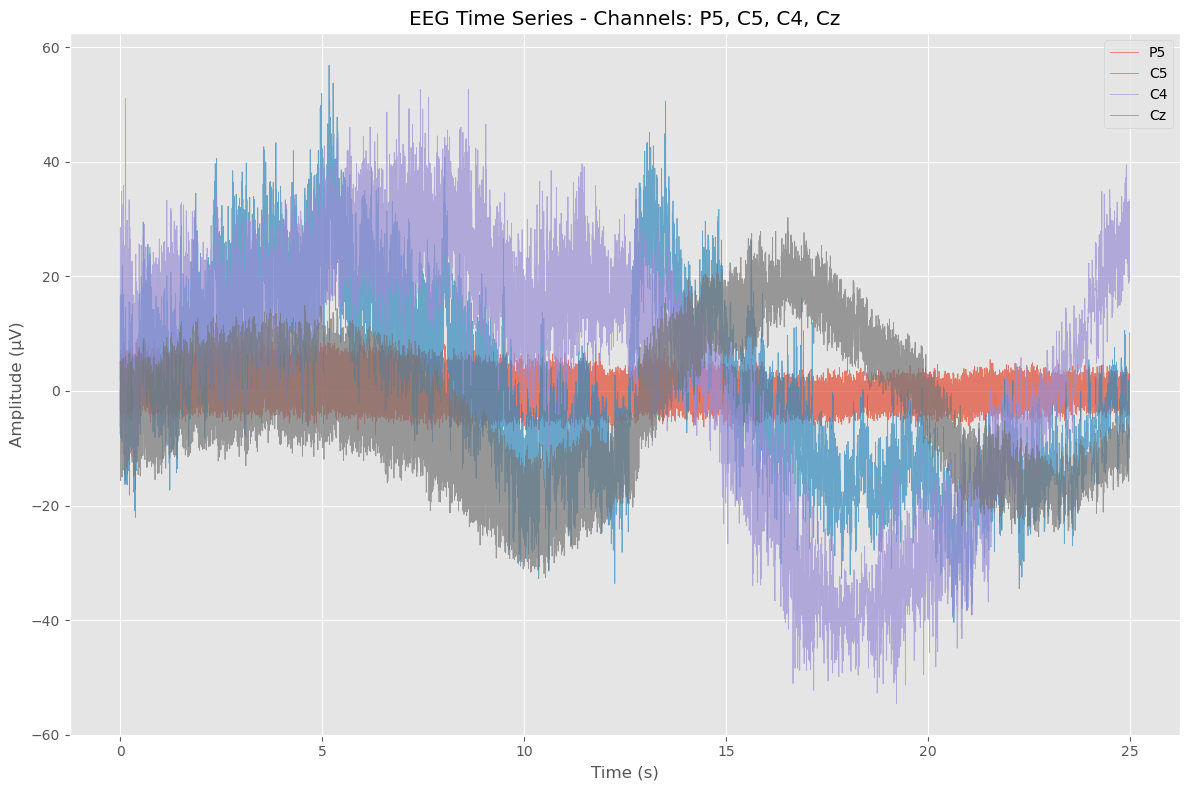

In [15]:
# Examine time domain

channels = ['P5', 'C5', 'C4', 'Cz']
time_range = [0,25]
plot_EEG_TD(temp_EEG_raw, channels, time_range)

                                                                                                  
                                       POWER SPECTRUM MODEL                                       
                                                                                                  
                        The model was run on the frequency range 1 - 75 Hz                        
                                 Frequency Resolution is 0.24 Hz                                  
                                                                                                  
                            Aperiodic Parameters (offset, exponent):                              
                                         -14.0442, 0.1337                                         
                                                                                                  
                                       1 peaks were found:                                        
          

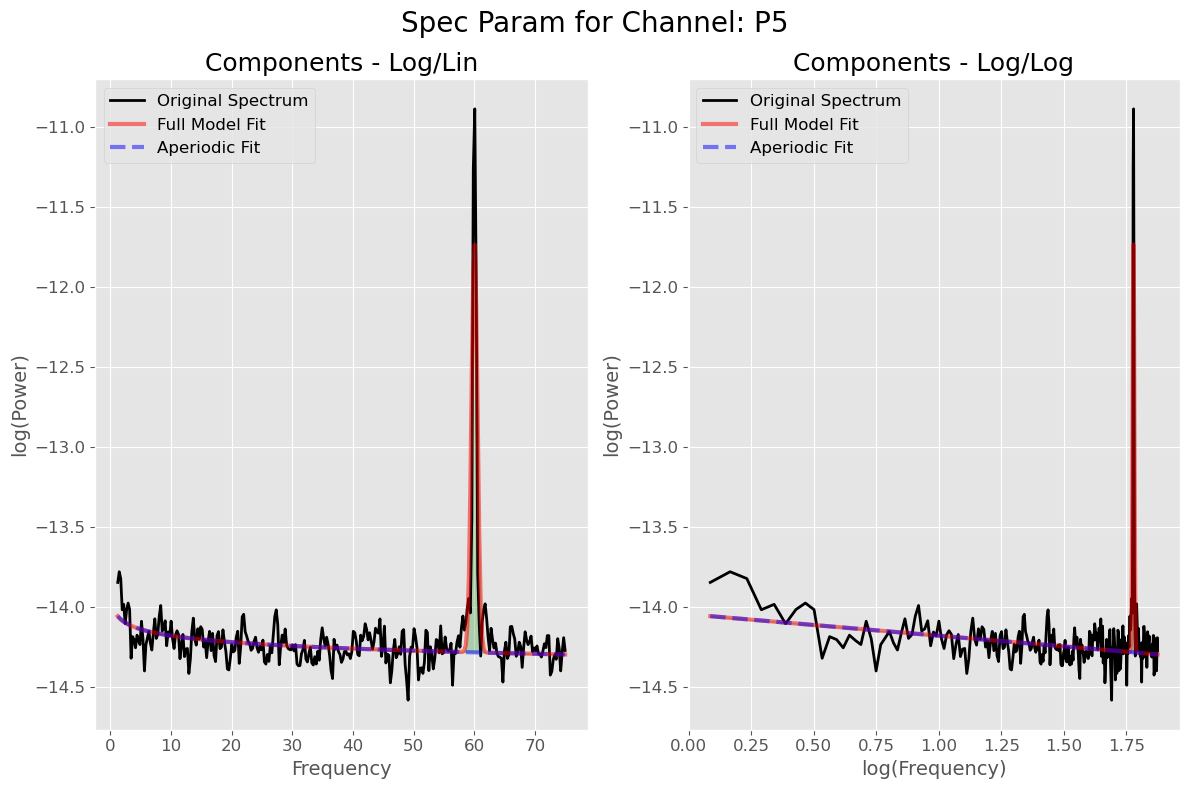

In [16]:
channel_idx = temp_spectra.ch_names.index('P5')
plot_SpecParam(fg, channel_idx, 'P5')